# Bayesian Optimization Example Using `mlos_core`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Define a fake "performance" function.
# In an actual application, we would not have access to this function directly.
# Instead, we could only measure the outcome by running an experiment, such as timing
# a particular run of the system.
def f(x):
    return (6*x-2)**2*np.sin(12*x-4)

def score_config(config: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(data=[f(config['x'].loc[0])], columns=['score'])

Text(0, 0.5, 'Objective (i.e. performance)')

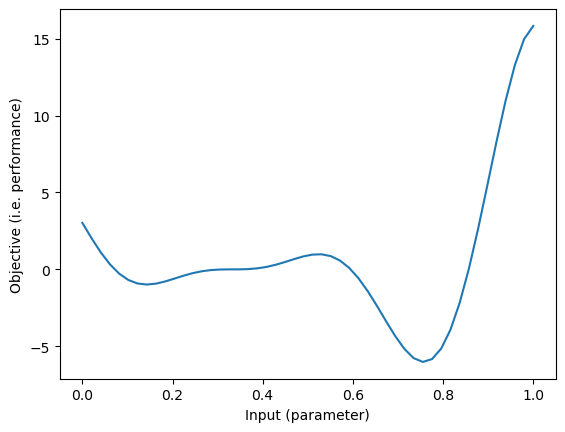

In [3]:
# define a domain to evaluate
line = np.linspace(0, 1)
# evaluate the function
values = f(line)
# plot the function
plt.plot(line, values)
plt.xlabel("Input (parameter)")
plt.ylabel("Objective (i.e. performance)")

In [4]:
import ConfigSpace as CS

# Start defining a ConfigurationSpace for the Optimizer to search.
input_space = CS.ConfigurationSpace(seed=1234)

# Add a single continuous input dimension between 0 and 1.
input_space.add(CS.UniformFloatHyperparameter(name='x', lower=0, upper=1))

In [5]:
import mlos_core.optimizers

In [6]:
# Choose an optimizer.

#optimizer = mlos_core.optimizers.RandomOptimizer(parameter_space=input_space, optimization_targets=['score'])

#optimizer = mlos_core.optimizers.FlamlOptimizer(parameter_space=input_space, optimization_targets=['score'])

optimizer = mlos_core.optimizers.SmacOptimizer(parameter_space=input_space, optimization_targets=['score']) # , seed=42, n_random_init=20)

In [7]:
# Inspect the chosen optimizer
optimizer

SmacOptimizer(space_adapter=None)

Now, we can run the actual optimization which will carry out the steps outlined above.

In [8]:
def run_optimization(optimizer: mlos_core.optimizers.BaseOptimizer):
    # get a new config value suggestion to try from the optimizer.
    (suggested_value, _metadata) = optimizer.suggest()
    # suggested value are dictionary-like, keys are input space parameter names
    # evaluate target function
    scores = score_config(suggested_value)
    #print(suggested_value, "\n", scores)
    optimizer.register(configs=suggested_value, scores=scores)

# run for some iterations
n_iterations = 15
for i in range(n_iterations):
    run_optimization(optimizer)

After 15 iterations, the model is likely to have captured the general shape, but probably not have found the actual optimum since the first few iterations are spent randomly exploring the space.

In [9]:
optimizer.get_observations()

(           x
 0   0.985143
 1   0.250745
 2   0.039215
 3   0.711113
 4   0.525156
 5   0.228304
 6   0.438647
 7   0.797999
 8   0.831501
 9   0.409664
 10  0.002271
 11  0.703873
 12  0.710294
 13  0.716369
 14  0.723490,
         score
 0   15.286830
 1   -0.205432
 2    1.177722
 3   -5.055697
 4    0.986147
 5   -0.378142
 6    0.380605
 7   -5.050101
 8   -2.684311
 9    0.166364
 10   2.914733
 11  -4.769083
 12  -5.024602
 13  -5.246319
 14  -5.477457,
 None)

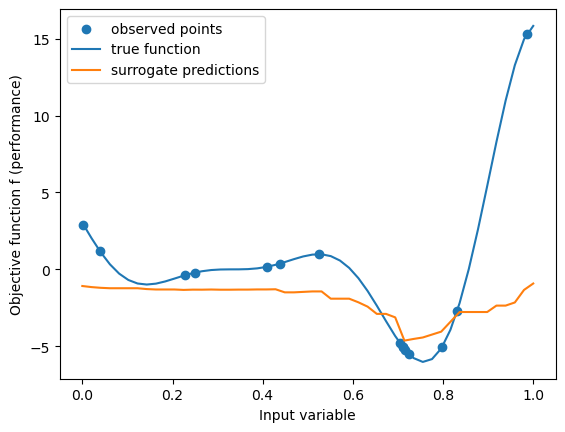

In [10]:
# evaluate the surrogate function
#
configs = pd.DataFrame(line.reshape(-1, 1), columns=['x'])
surrogate_predictions = optimizer.surrogate_predict(configs=configs)

# plot the observations
#
(observations, scores, _contexts) = optimizer.get_observations()
plt.scatter(observations.x, scores, label='observed points')

# plot the true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
# alpha = optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha
# t_values = t.ppf(1 - alpha / 2.0, surrogate_predictions['predicted_value_degrees_of_freedom'])
# ci_radii = t_values * np.sqrt(surrogate_predictions['predicted_value_variance'])
# value = surrogate_predictions['predicted_value']
plt.plot(line, surrogate_predictions, label='surrogate predictions')
#plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
#plt.plot(line, -optimizer.experiment_designer.utility_function(optimization_problem.construct_feature_dataframe(pd.DataFrame({'x': line}))), ':', label='utility_function')
plt.ylabel("Objective function f (performance)")
plt.xlabel("Input variable")
plt.legend()
plt.show()

We can find the best value according to the current surrogate with the ``optimum`` method:

In [11]:
optimizer.get_best_observations()

(          x
 14  0.72349,
        score
 14 -5.477457,
 None)

We can run more iterations to improve the surrogate model and the optimum that is found:

In [12]:
# run for more iterations
n_iterations = 50
for i in range(n_iterations):
    run_optimization(optimizer)

There is some improvement in the optimum:

In [13]:
optimizer.get_best_observations()

(           x
 42  0.757248,
       score
 42 -6.02074,
 None)

We can now visualize the surrogate model and optimization process again. The points are colored according to the iteration number, with dark blue points being early in the process and yellow points being later. You can see that at the end of the optimization, the points start to cluster around the optimum.
The region to the right is not explored much because the surrogate model predicts that it is not likely to contain the optimum and hence also doesn't have as much accuracy compared to the real function there.

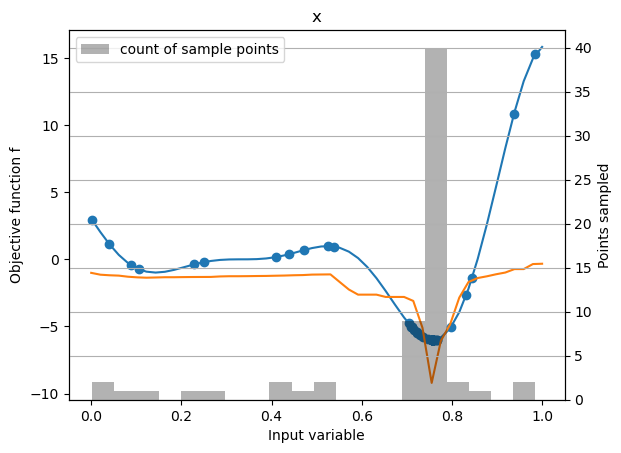

In [15]:
# evaluate the surrogate function
#
configs = pd.DataFrame(line.reshape(-1, 1), columns=['x'])
surrogate_predictions = optimizer.surrogate_predict(configs=configs)

# plot the observations
#
(observations, scores, _contexts) = optimizer.get_observations()
plt.scatter(observations.x, scores, label='observed points')

# plot true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
#ci_raduii = surrogate_predictions['prediction_ci']
plt.plot(line, surrogate_predictions, label='surrogate predictions')
#plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
#plt.plot(line, -optimizer.utility_function(pd.DataFrame({'x': line})), ':', label='utility_function')

ax = plt.gca()
ax.set_ylabel("Objective function f")
ax.set_xlabel("Input variable")
bins_axes = ax.twinx()
bins_axes.set_ylabel("Points sampled")
pd.DataFrame(observations.x).hist(bins=20, ax=bins_axes, alpha=.3, color='k', label="count of sample points")
plt.legend()